In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!git pull

Already up to date.


In [3]:
import os
import logging
import argparse

import numpy as np
import matplotlib
from matplotlib.ticker import StrMethodFormatter
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline

/Data/repos/zoobot/zoobot/estimators/make_predictions.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/data/miniconda3/envs/zoobot/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/miniconda3/envs/zoobot/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 

/Data/repos/zoobot/zoobot/uncertainty/discrete_coverage.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/data/miniconda3/envs/zoobot/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/miniconda3/envs/zoobot/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/ipykernel/kernelapp.py", line

/Data/repos/zoobot/zoobot/active_learning/metrics.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/data/miniconda3/envs/zoobot/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/miniconda3/envs/zoobot/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, 

In [4]:
!pwd

/Data/repos/zoobot/notebooks


In [70]:
# QUESTION = 'bars'
QUESTION = 'smooth'

NEW_PREDICTIONS = False
# NEW_PREDICTIONS = True

### Load the (latest) model under `model_name` folder in `results_dir`

In [71]:
results_dir = '../results'
if QUESTION == 'smooth':
    shard_dir = '../data/gz2_shards/uint8_256px_smooth_n_full'
elif QUESTION == 'bars':
    shard_dir = '../data/gz2_shards/uint8_256px_bar_n_full'  # for random train/test
#     shard_dir = '../data/gz2_shards/uint8_256px_bar_n_full_nair'

tfrecord_loc = os.path.join(shard_dir, 's256_shard_0.tfrecord')  # NAIR ONLY, unlabelled shards are in the root
# tfrecord_loc = os.path.join(shard_dir, 'eval_shards/s256_shard_0.tfrecord')

#### Download previously trained model (only if new predictions needed)

In [72]:
if QUESTION == 'smooth':
    model_name = 'smooth-full'
    if NEW_PREDICTIONS:
#     128px smooth model
        !aws s3 sync s3://galaxy-zoo/results/smooth_full_96px_greyscale_9d8345e4/iteration_0/estimators/1550930190 {results_dir}/{model_name}
elif QUESTION == 'bars':
    # 128px color bars model:
    model_name = 'bars-full'
    # or 1551129992?
#     model_name = 'bars-full-nair'
    if NEW_PREDICTIONS:  # question, which to use?
        !aws s3 sync s3://galaxy-zoo/results/bars_full_128px_f084ba4_final/iteration_0/estimators/1551130721 {results_dir}/{model_name}
#         !aws s3 sync s3://galaxy-zoo/results/al_baseline_nair_bars_slightly_incomplete_8cc163c/iteration_0/estimators/1551220527 {results_dir}/{model_name}

#### Download previously-made shards (only if new predictions needed)

In [73]:
if NEW_PREDICTIONS:
    if QUESTION == 'smooth':
        if not os.path.isdir(shard_dir):
            !dvc pull -r s3 ../make_shards_smooth_full.dvc
    elif QUESTION == 'bars':
        if not os.path.isdir(shard_dir):
    #         !dvc pull -r s3 ../make_shards_bar_full.dvc
            !dvc pull -r s3 ../make_shards_bar_full_nair.dvc


### Load DECALS or GZ2 Catalog (to later construct SimulatedModel (i.e. model + labels) )

#### Option 1. DECALS Catalog

In [74]:
# simulation_timeline.ATTR_STRS 

In [75]:
# add in catalog details for more metrics
# spiral_strs = ['has-spiral-arms_yes', 'spiral-winding_prediction-encoded']
# merger_strs = ['merging_merger','merging_tidal-debris-v1' ,'merging_both-v1','merging_neither-v1','merging_major-disturbance','merging_minor-disturbance','merging_none']
# usecols = simulation_timeline.ATTR_STRS + ['subject_id', 'smooth-or-featured_smooth_fraction'] + merger_strs + spiral_strs + ['smooth-or-featured_artifact']
# spiral_strs = []
# merger_strs = []
# usecols = None

# catalog = pd.read_csv(os.path.join(shard_dir, 'labelled_catalog.csv'))

#### Option 2. GZ2 Catalog

In [76]:
gz2_catalog_loc = '../data/gz2_classifications_and_subjects.csv'
if not os.path.isfile(gz2_catalog_loc):
    !dvc pull -r s3 {gz2_catalog_loc}.dvc

+-------------------------------------------+
|                                           |
|     Update available 0.35.7 -> 0.40.1     |
|       Run pip install dvc --upgrade       |
|                                           |
+-------------------------------------------+

ERROR: failed to pull data from the cloud - '../data/gz2_classifications_and_subjects.csv.dvc' does not exist.

Having any troubles?. Hit us up at https://dvc.org/support, we are always happy to help!


In [77]:
!ls ../data/gz2

gz2_classifications_and_subjects.csv
gz2_classifications_and_subjects.csv.dvc
master_catalog.csv
master_catalog_pretend_ec2.csv
png
png.tar
png.tar.dvc
previous_classifications_renamed.csv
previous_classifications_renamed.csv.dvc
shards


In [78]:
# I messed up dvc a bit here, no worries

In [79]:
gz2_catalog = pd.read_csv('../data/gz2/gz2_classifications_and_subjects.csv', usecols=None, dtype={'subject_id': str})

In [80]:
# gz2 catalog doesn't have nsa, let's merge that in for astro features
nsa_catalog_loc = '../data/nsa_v1_0_1.fits'
if not os.path.isfile(nsa_catalog_loc):
    !dvc pull -r s3 {nsa_catalog_loc}.dvc

In [81]:
nsa_catalog = Table.read(nsa_catalog_loc)[['RA', 'DEC', 'Z']]
nsa_catalog['ra'] = nsa_catalog['RA']
del nsa_catalog['RA']
nsa_catalog['dec'] = nsa_catalog['DEC']
del nsa_catalog['DEC']
nsa_catalog['redshift'] = nsa_catalog['Z']
del nsa_catalog['Z']
nsa_catalog = nsa_catalog.to_pandas()

In [82]:
catalog, _ = matching_utils.match_galaxies_to_catalog_pandas(gz2_catalog, nsa_catalog, matching_radius=u.arcsec * 1000)

In [83]:
len(catalog), len(gz2_catalog), len(nsa_catalog)

(239686, 239695, 641409)

In [84]:
# to conserve memory
del gz2_catalog
del nsa_catalog

In [85]:
# rename for consistency with Panoptes
catalog['smooth-or-featured_smooth_fraction'] = catalog['t01_smooth_or_features_a01_smooth_fraction']
# etc, as needed
catalog['smooth-or-featured_total-votes'] = catalog['t01_smooth_or_features_a01_smooth_count'] + catalog['t01_smooth_or_features_a02_features_or_disk_count'] + catalog['t01_smooth_or_features_a03_star_or_artifact_count']
catalog['bar_total-votes'] = catalog['t03_bar_a06_bar_count'] + catalog['t03_bar_a07_no_bar_count']

In [86]:
catalog['subject_id'] = catalog['id'].astype(str)
if QUESTION == 'smooth':
    catalog['total_votes']  = catalog['smooth-or-featured_total-votes']
    catalog['label']  = catalog['t01_smooth_or_features_a01_smooth_count']
elif QUESTION == 'bars':
    catalog['total_votes']  = catalog['bar_total-votes']
    catalog['label']  = catalog['t03_bar_a06_bar_count']

### Predict many rho for the galaxies in tfrecord_loc. Record id_strs to join into catalog later.

In [87]:
# Figures will be saved to here
save_dir = '../analysis/uncertainty/al-binomial/{}'.format(model_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
single_model_name = '{}-single'.format(model_name)
single_save_dir = '../analysis/uncertainty/al-binomial/{}'.format(single_model_name)
if not os.path.exists(single_save_dir):
    os.mkdir(single_save_dir)
assert single_save_dir != save_dir

**Stop here if you're reloading from saved predictions**

In [ ]:
assert NEW_PREDICTIONS

In [ ]:
# N_SAMPLES = 200
N_SAMPLES = 30  # for Nair

# n_galaxies = 2500
n_galaxies = 6000  # for Nair

tfrecord_loc = [os.path.join(shard_dir, 's256_shard_0.tfrecord'), os.path.join(shard_dir, 's256_shard_1.tfrecord')] # NAIR ONLY, unlabelled shards are in the root

images, id_strs, samples = check_uncertainty.calculate_predictions(
    tfrecord_loc, n_galaxies, results_dir, model_name, inital_size=256, n_samples=N_SAMPLES)
assert samples.shape[1] == N_SAMPLES

In [ ]:
if QUESTION == 'smooth':
    EXPECTED_VOTES = [40 for n in range(len(samples))]
elif QUESTION == 'bars':
    EXPECTED_VOTES = [10 for n in range(len(samples))]

In [48]:
subjects = [{'matrix': images[n], 'id_str': id_strs[n].decode('utf-8')} for n in range(len(id_strs))]
acquisitions = acquisition_utils.mutual_info_acquisition_func(samples, expected_votes=EXPECTED_VOTES)
metrics.save_iteration_state(save_dir, subjects, samples, acquisitions=acquisitions)

Repeat for single model

In [49]:
images, id_strs, samples = check_uncertainty.calculate_predictions(
    tfrecord_loc, n_galaxies, results_dir, model_name, inital_size=256, n_samples=1) # normal model name, for path

INFO:tensorflow:Restoring parameters from ../results/bars-full-nair/variables/variables


INFO:tensorflow:Restoring parameters from ../results/bars-full-nair/variables/variables


In [50]:
subjects = [{'matrix': images[n], 'id_str': id_strs[n].decode('utf-8')} for n in range(len(id_strs))]
acquisitions = acquisition_utils.mutual_info_acquisition_func(samples, expected_votes=EXPECTED_VOTES)
metrics.save_iteration_state(single_save_dir, subjects, samples, acquisitions=acquisitions)

In [51]:
# model.show_mutual_info_vs_predictions(save_dir)

In [52]:
!dvc add {save_dir}
!dvc push -r s3 {save_dir}.dvc

Adding '../analysis/uncertainty/al-binomial/bars-full-nair' to '../analysis/uncertainty/al-binomial/.gitignore'.
Saving '../analysis/uncertainty/al-binomial/bars-full-nair' to cache '../.dvc/cache'.
Linking directory '../analysis/uncertainty/al-binomial/bars-full-nair'.
Saving information to '../analysis/uncertainty/al-binomial/bars-full-nair.dvc'.

To track the changes with git run:

	git add ../analysis/uncertainty/al-binomial/.gitignore ../analysis/uncertainty/al-binomial/bars-full-nair.dvc


In [54]:
!dvc add {single_save_dir}
!dvc push -r s3 {single_save_dir}.dvc

Adding '../analysis/uncertainty/al-binomial/bars-full-nair-single' to '../analysis/uncertainty/al-binomial/.gitignore'.
Saving '../analysis/uncertainty/al-binomial/bars-full-nair-single' to cache '../.dvc/cache'.
Linking directory '../analysis/uncertainty/al-binomial/bars-full-nair-single'.
Saving information to '../analysis/uncertainty/al-binomial/bars-full-nair-single.dvc'.

To track the changes with git run:

	git add ../analysis/uncertainty/al-binomial/.gitignore ../analysis/uncertainty/al-binomial/bars-full-nair-single.dvc
Preparing to upload data to 's3://galaxy-zoo/dvc/zoobot'
Preparing to collect status from s3://galaxy-zoo/dvc/zoobot
[##############################] 100% Collecting information
[##############################] 100% Analysing status.
(1/2): [##############################] 100% ../analysis/uncertainty/al-binomial/bars-full-nair-single
(2/2): [##############################] 100% ../analysis/uncertainty/al-binomial/bars-full-nair-single/state.pickle


### Load the Saved Predictions

In [88]:
state = metrics.load_iteration_state(save_dir)
model = metrics.Model(state, name=model_name)
assert set(model.id_strs) - set(catalog['subject_id'].values) == set()

In [89]:
sim_model = simulated_metrics.SimulatedModel(model, catalog)

/Data/repos/zoobot/zoobot/active_learning/simulated_metrics.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filtered_catalog['subject_id'] = filtered_catalog['subject_id'].astype(str)


Repeat for single

In [90]:
single_state = metrics.load_iteration_state(single_save_dir)
single_model = metrics.Model(single_state, name=model_name)

In [91]:
single_sim_model = simulated_metrics.SimulatedModel(single_model, catalog)

/Data/repos/zoobot/zoobot/active_learning/simulated_metrics.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filtered_catalog['subject_id'] = filtered_catalog['subject_id'].astype(str)


Are they the same galaxies?

In [92]:
assert state.id_strs == single_state.id_strs

In [93]:
single_sim_model.labels 

array([49, 11, 42, ..., 38, 28, 24])

In [94]:
sim_model.labels

array([31, 18, 21, ..., 13,  7,  2])

(array([ 95.,  59.,  47.,  47.,  33.,  17.,  41.,  30.,  52.,  57.,  43.,
         31.,  50.,  79.,  78., 131., 136.,  79., 192., 241., 313., 244.,
        171.,  71.,  70.,  44.,  20.,  18.,   8.,   3.]),
 array([ 0.        ,  1.83333333,  3.66666667,  5.5       ,  7.33333333,
         9.16666667, 11.        , 12.83333333, 14.66666667, 16.5       ,
        18.33333333, 20.16666667, 22.        , 23.83333333, 25.66666667,
        27.5       , 29.33333333, 31.16666667, 33.        , 34.83333333,
        36.66666667, 38.5       , 40.33333333, 42.16666667, 44.        ,
        45.83333333, 47.66666667, 49.5       , 51.33333333, 53.16666667,
        55.        ]),
 <a list of 30 Patch objects>)

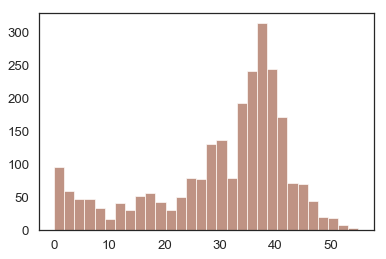

In [95]:
fig, ax = plt.subplots()
alpha = 0.6
ax.hist(single_sim_model.labels, bins=30, alpha=alpha)
ax.hist(sim_model.labels, bins=30, alpha=alpha)

They are, but in a different order - remember, catalogs are sorted by acquisition value

((array([366., 599., 752., 380., 150., 140.,  67.,  26.,  12.,   8.]),
  array([37. , 39.8, 42.6, 45.4, 48.2, 51. , 53.8, 56.6, 59.4, 62.2, 65. ]),
  <a list of 10 Patch objects>),
 44.1892)

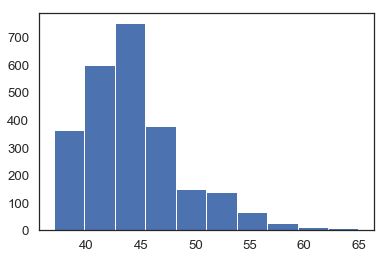

In [96]:
# to check that the right models have been loaded - should be around 40 for smooth, 0-40 for bars
plt.hist(sim_model.total_votes), sim_model.total_votes.mean()

### Visualise Posteriors

Check for systematic offset - in general, model seems slightly skewed towards low k?

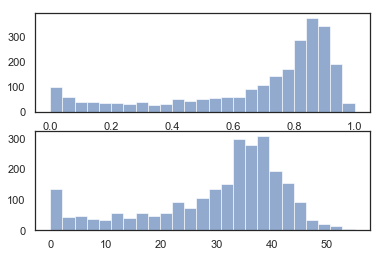

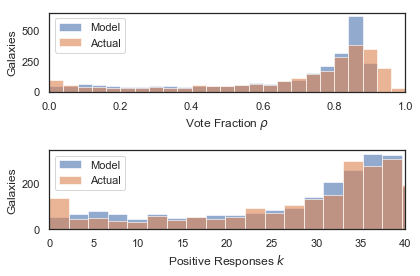

In [97]:
# sns.set_context('paper')
sns.set(font_scale=1.)
sns.set_style('white')
# matplotlib.rcParams.update({'font.size': 50}

# dummy for bins
fig, (ax0, ax1) = plt.subplots(nrows=2)
_, bins_rho, _ = ax0.hist(sim_model.labels/ sim_model.total_votes, bins=25, alpha=alpha, label='Actual')
_, bins_k, _ = ax1.hist(sim_model.labels, bins=25, alpha=alpha, label='Actual')

fig, (ax0, ax1) = plt.subplots(nrows=2)

_, bins, _ = ax0.hist(sim_model.mean_rho_prediction, bins=bins_rho, alpha=alpha, label='Model')
ax0.hist(sim_model.labels/ sim_model.total_votes, bins=bins_rho, alpha=alpha, label='Actual')
ax0.set_xlabel(r'Vote Fraction $\rho$')
ax0.set_ylabel('Galaxies')
ax0.legend()
ax0.set_xlim([0., 1.])

_, bins, _ = ax1.hist(sim_model.expected_k_prediction, bins=bins_k, alpha=alpha, label='Model')
ax1.hist(sim_model.labels, bins=bins_k, alpha=alpha, label='Actual')
ax1.set_xlabel(r'Positive Responses $k$')
ax1.set_ylabel('Galaxies')
ax1.legend()
ax1.set_xlim([0, 40])

fig.tight_layout()
# fig.savefig(os.path.join(save_dir, 'posterior_over_full_sample.png'))
# fig.savefig(os.path.join(save_dir, 'posterior_over_full_sample.pdf'))

In [98]:
def custom_samples(samples, labels, total_votes):
    sns.set_context('paper', font_scale=1.5)
    fig, axes = plt.subplots(nrows=len(labels), figsize=(3, len(labels)*1.5), sharex=True)
    make_predictions.plot_samples(samples, labels, total_votes, fig, axes, alpha=0.06)
    for ax in axes:
        ax.set_xlim([0, 50])
    
    for n in range(len(labels)):
#         axes[n].set_ylabel(r'$p(v|D)$', visible=True)
        axes[n].set_ylabel(r'$p(v|w)$', visible=True)
        axes[n].yaxis.set_visible(True)
    
    axes[-1].set_xlabel('Volunteer Votes')
    fig.tight_layout()

    axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )
    fig.tight_layout()
    return fig

In [99]:
def custom_samples_with_galaxies(sim_model, selected_slice):
    
    samples = np.array(sim_model.model.samples)[selected_slice]
    labels = np.array(sim_model.labels)[selected_slice]
    total_votes = sim_model.total_votes[selected_slice]
    catalog = sim_model.catalog[selected_slice]
    
    
    sns.set_context('paper', font_scale=1.5)
    
    im_width = 2
    single_width = 3
    multiple_width = 3
    height = im_width
    
    fig = plt.figure(figsize=(0.8 * len(labels) * height / 1.5, 0.8 * (im_width + single_width + multiple_width) * 1.75))
    gs = gridspec.GridSpec(len(labels) * height, im_width + single_width + multiple_width)  # y, x format
    image_axes = []
    single_axes = []
    multiple_axes = []
    for galaxy_n in range(len(labels)):
        x_slice = slice(galaxy_n*height, (galaxy_n+1)*height)
        image_axes.append(plt.subplot(gs[x_slice, :im_width]))
        single_axes.append(plt.subplot(gs[x_slice, im_width:im_width+single_width]))
        multiple_axes.append(plt.subplot(gs[x_slice, im_width+single_width:]))
    

#     fig, axes = plt.subplots(nrows=len(labels), figsize=(3, len(labels)*1.5), sharex=True)
    make_predictions.plot_samples(samples[:, :1], labels, total_votes, fig, single_axes, alpha=0.06)
    for ax in single_axes:
        ax.set_xlim([0, 50])

    make_predictions.plot_samples(samples, labels, total_votes, fig, multiple_axes, alpha=0.06)
    for ax in multiple_axes:
        ax.set_xlim([0, 50])
        
        
    for ax_n, ax in enumerate(image_axes):
        plot_galaxy(catalog.iloc[ax_n]['png_loc'], ax)
        
    
    for n in range(len(labels)):
        multiple_axes[n].set_ylabel(r'$p(k|N, D)$', visible=True)
        multiple_axes[n].yaxis.set_visible(True)
        single_axes[n].set_ylabel(r'$p(k|N, w)$', visible=True)
        single_axes[n].yaxis.set_visible(True)
        single_axes[n].yaxis.set_major_locator(plt.NullLocator())
        multiple_axes[n].yaxis.set_major_locator(plt.NullLocator())
        if n < len(labels) - 1:
            single_axes[n].xaxis.set_major_locator(plt.NullLocator())
            multiple_axes[n].xaxis.set_major_locator(plt.NullLocator())
    
    if QUESTION == 'bars':
        question = 'Bar'
    else:
        question = 'Smooth'
    single_axes[-1].set_xlabel(r"$k$ '{}' votes, of $N$ total".format(question))
    multiple_axes[-1].set_xlabel(r"$k$ '{}' votes, of $N$ total".format(question))
    fig.tight_layout()

    single_axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )
    
    multiple_axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )

    
    fig.tight_layout()
    return fig

In [100]:
def plot_galaxy(image_loc, ax, n_examples=10, crop=0):
    im_size = 424
    im = Image.open(image_loc)
    if QUESTION == 'bars':
        crop = 120
    else:
        crop = 35
    cropped_im = im.crop((crop, crop, 424 - crop, 424 - crop))
    ax.imshow(cropped_im)
    ax.grid(False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)


In [101]:
# fig, axes = plt.subplots(1, 10, figsize=(20, 12))
# for ax_n, ax in enumerate(axes):
#     plot_galaxy(sim_model.catalog.iloc[ax_n]['png_loc'], ax)

In [102]:
# 1 2

In [103]:
selected = slice(80, 73, -1)  # smooth

# selected = slice(0, 7)

if QUESTION == 'bars':
    selected = slice(0, 7)

In [104]:
# np.array(sim_model.model.samples)[selected, :]
# np.array(sim_model.labels)[selected]
# sim_model.catalog['smooth-or-featured_total-votes'][selected]

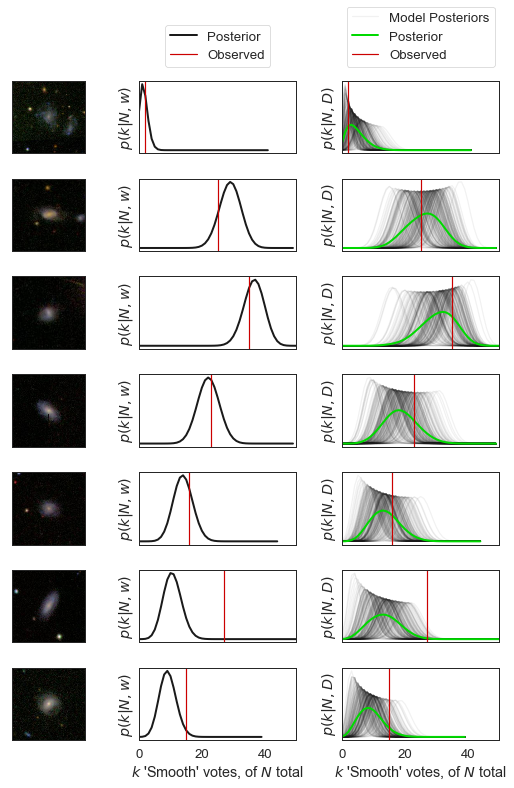

In [105]:
fig = custom_samples_with_galaxies(sim_model, selected)
# fig.savefig(os.path.join(save_dir, 'mc_model_{}.png'.format(len(np.array(sim_model.labels)[selected]))))
# fig.savefig(os.path.join(save_dir, 'mc_model_{}.pdf'.format(len(np.array(sim_model.labels)[selected]))))

In [106]:
# be sure to switch label in custom_samples before running this
# fig = custom_samples(np.array(single_sim_model.model.samples)[selected, :1], np.array(single_sim_model.labels)[selected], total_votes=single_sim_model.total_votes)
# fig.savefig(os.path.join(save_dir, 'single_model_{}.png'.format(len(np.array(sim_model.labels)[selected]))))
# fig.savefig(os.path.join(save_dir, 'single_model_{}.eps'.format(len(np.array(sim_model.labels)[selected]))))

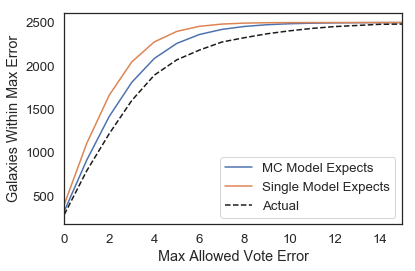

In [107]:
sns.set(font_scale=1.2)
sns.set_style('white')

fig, ax = plt.subplots()
ungrouped_coverage_df = discrete_coverage.evaluate_discrete_coverage(
    sim_model.labels, 
    sim_model.bin_probs)
coverage_df = ungrouped_coverage_df.groupby('max_state_error').agg({'prediction': 'sum', 'observed': 'sum'}).reset_index()

ungrouped_single_coverage_df = discrete_coverage.evaluate_discrete_coverage(
    single_sim_model.labels, 
    single_sim_model.bin_probs)
single_coverage_df = ungrouped_single_coverage_df.groupby('max_state_error').agg({'prediction': 'sum', 'observed': 'sum'}).reset_index()


plt.plot(coverage_df['max_state_error'], coverage_df['prediction'], label='MC Model Expects')
plt.plot(single_coverage_df['max_state_error'], single_coverage_df['prediction'], label='Single Model Expects')
plt.plot(single_coverage_df['max_state_error'], coverage_df['observed'], 'k--', label='Actual')

ax.set_xlabel('Max Allowed Vote Error')
ax.set_ylabel('Galaxies Within Max Error')
ax.legend()
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))  # must expect 'x' kw arg

ax.set_xlim([0, 15])
fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'coverage_comparison_200_samples.png'))
fig.savefig(os.path.join(save_dir, 'coverage_comparison_200_samples.pdf'))

In [108]:
ungrouped_coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_ungrouped_coverage_df.csv'), index=False)
ungrouped_single_coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_ungrouped_coverage_df.csv'), index=False)

In [109]:
coverage_df['error'] = coverage_df['prediction'] - coverage_df['observed']
coverage_df['relative_error'] = coverage_df['error'] / coverage_df['observed']
coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_coverage_df.csv'), index=False)
coverage_df.head(20)

,max_state_error,prediction,observed,error,relative_error
0,0,322.654001,284.0,38.654001,0.136106
1,1,913.238608,790.0,123.238608,0.155998
2,2,1417.275072,1218.0,199.275072,0.163608
3,3,1810.095981,1601.0,209.095981,0.130603
4,4,2085.566661,1893.0,192.566661,0.101726
5,5,2259.370890,2070.0,189.370890,0.091484
6,6,2361.568301,2182.0,179.568301,0.082295
7,7,2420.474026,2275.0,145.474026,0.063945
8,8,2454.665095,2325.0,129.665095,0.055770
9,9,2474.455017,2370.0,104.455017,0.044074


In [110]:
single_coverage_df['error'] = single_coverage_df['prediction'] - single_coverage_df['observed']
single_coverage_df['relative_error'] = single_coverage_df['error'] / single_coverage_df['observed']
single_coverage_df.to_csv(os.path.join(save_dir, QUESTION + '_single_coverage_df.csv'), index=False)
single_coverage_df.head(20)

,max_state_error,prediction,observed,error,relative_error
0,0,399.024943,280.0,119.024943,0.425089
1,1,1106.083270,762.0,344.083270,0.451553
2,2,1662.113450,1175.0,487.113450,0.414565
3,3,2046.140366,1535.0,511.140366,0.332990
4,4,2276.299944,1797.0,479.299944,0.266722
5,5,2397.674128,1973.0,424.674128,0.215243
6,6,2455.855429,2110.0,345.855429,0.163913
7,7,2481.948075,2205.0,276.948075,0.125600
8,8,2493.009214,2276.0,217.009214,0.095347
9,9,2497.442349,2336.0,161.442349,0.069111


TODO - I might consider adding an MSE model as a comparison, to hopefully beat. I think this might be quite similar though. Ideally I can compare this with previous work somehow.

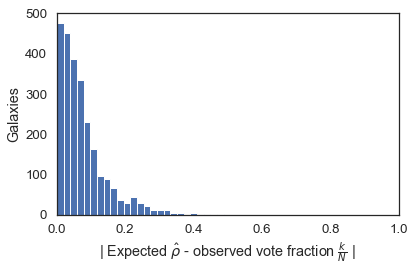

In [375]:
sns.set(font_scale=1.2)
sns.set_style('white')
fig, ax = plt.subplots()
ax.hist(sim_model.abs_rho_error, bins=25)
# ax.axvline(sim_model.mean_abs_rho_error, color='r') 
ax.set_xlim([0, 1.])
ax.set_ylabel('Galaxies')
ax.set_xlabel(r'| Expected $\hat{\rho}$ - observed vote fraction $\frac{k}{N}$ |')
fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'difference_in_rho.png'))
fig.savefig(os.path.join(save_dir, 'difference_in_rho.pdf'))

In [376]:
sim_model.abs_rho_error.mean(), single_sim_model.abs_rho_error.mean()

(0.07371434826343053, 0.0801696078036403)

In [377]:
np.sqrt(sim_model.mean_abs_rho_error), np.sqrt(single_sim_model.mean_abs_rho_error)  

(0.27150386417771394, 0.2831423807974361)

In [378]:
np.sqrt(sim_model.mean_square_rho_error), np.sqrt(single_sim_model.mean_square_rho_error) # this is the rmse

(0.10059991566109969, 0.1106224689514013)

In [379]:
# alpha = 0.3
# n_bins = 25

# # dummy for bins
# fig, ax = plt.subplots()
# _, bins, _  = ax.hist(sim_model.labels / sim_model.total_votes, bins=n_bins, alpha=alpha, label=r'Observed $\rho$')
# ax.hist(sim_model.mean_rho_prediction, bins=n_bins, alpha=alpha, label=r'Mean Rho Prediction $\hat{\rho}}$')
# # ax.hist(single_sim_model.mean_rho_prediction, bins=bins, alpha=alpha, label=r'Single Rho Prediction $\hat{\rho}}$')

# fig, ax = plt.subplots()
# sns.set(font_scale=1.)
# sns.set_style('white')

# ax.hist(sim_model.mean_rho_prediction, bins=bins, alpha=alpha, label=r'Mean Rho Prediction $\hat{\rho}}$')
# # ax.hist(single_sim_model.mean_rho_prediction, bins=bins, alpha=alpha, label=r'Single Rho Prediction $\hat{\rho}}$')
# ax.hist(sim_model.labels / sim_model.total_votes, bins=bins, alpha=alpha, label=r'Observed $\rho$')
# ax.legend()
# ax.set_xlim([0., 1.])
# ax.set_ylabel('Galaxies')
# ax.set_xlabel(r'Typical vote fraction $\rho$')
# fig.tight_layout()
# fig.savefig(os.path.join(save_dir, 'typical_vote_fraction_distribution.png'))

# This is a repeat of the above histograms

In [380]:
np.sum(sim_model.mean_rho_prediction > 0.5), np.sum(single_sim_model.mean_rho_prediction > 0.5), np.sum((sim_model.labels / sim_model.total_votes) > 0.5)

(1911, 1896, 1944)

In [381]:
(sim_model.labels / sim_model.total_votes).min(), (sim_model.labels / sim_model.total_votes).max()

(0.0, 1.0)

In [382]:
sim_model.mean_rho_prediction.min(), sim_model.mean_rho_prediction.max()

(0.0018710280444838646, 0.9033543878793716)

In [383]:
single_sim_model.mean_rho_prediction.min(), single_sim_model.mean_rho_prediction.max()

(0.00062463158974424, 0.9515835046768188)

In [384]:
sim_model.total_votes

array([46, 44, 47, ..., 42, 49, 52])

### Replicate (ish) Sanchez 2017 ROC Curves

In [385]:
confusion_matrix((sim_model.labels / sim_model.total_votes) > 0.5, sim_model.mean_rho_prediction > 0.5)

array([[ 490,   66],
       [  99, 1845]])

In [386]:
 1 - ((66 + 99) / (490 + 1845 + 66 + 99))

0.9339999999999999

In [387]:
 1 - ((189 + 81) / (1858 + 189 + 81 + 372))

0.892

In [388]:
df = pd.DataFrame(data={
    'total_votes': sim_model.total_votes, 
    'k': sim_model.labels, 
    'vote_fraction': (sim_model.labels / sim_model.total_votes), 
    'rho_prediction': sim_model.mean_rho_prediction,
    'png_loc': sim_model.catalog.png_loc
})
df['smooth'] = df['vote_fraction'] > 0.5
df['confidence_proxy'] = np.abs(0.5 - df['rho_prediction'])
df = df.sort_values('confidence_proxy', ascending=False)

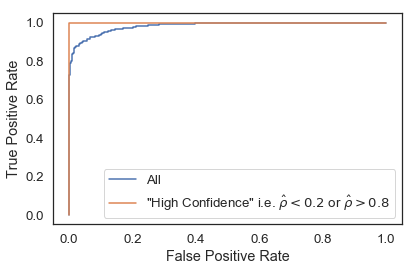

In [389]:
fig, ax = plt.subplots()
sns.set(font_scale=1.2)
sns.set_style('white')

fpr, tpr, _ = roc_curve(df['smooth'], df['rho_prediction'])
ax.plot(fpr, tpr, label='All')
df_low_entropy = df[df['confidence_proxy'] > 0.3]
fpr, tpr, _ = roc_curve(df_low_entropy['smooth'], df_low_entropy['rho_prediction'])
ax.plot(fpr, tpr, label=r'"High Confidence" i.e. $\hat{\rho} < 0.2$ or $\hat{\rho} > 0.8$')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'roc_curve.png'))
fig.savefig(os.path.join(save_dir, 'roc_curve.pdf'))

In [390]:
len(df), len(df_low_entropy)

(2500, 1420)

### Replicate(ish) Khan 2018 Confusion Matrices

> After selecting the OBJIDs from Table 2 based on the probability thresholds of 0.985 and 0.926 for spirals and ellipticals respectively,

In [391]:
from scipy.stats import binom


In [392]:
df.sample(1)

,total_votes,k,vote_fraction,rho_prediction,png_loc,smooth,confidence_proxy
974,44,36,0.818182,0.819713,/Volumes/alpha/gz2/png/587739/5877396096978126...,True,0.319713


In [393]:
cdf_array = binom.cdf((df['total_votes'] / 2.).astype(int), df['total_votes'], df['rho_prediction'])

In [394]:
(df['total_votes'] / 2.).astype(int).sample(10)

683     23
912     19
1984    19
674     21
1692    21
695     20
540     25
1286    21
1714    22
137     22
Name: total_votes, dtype: int64

In [395]:
df['total_votes'].sample(10)

770     44
24      37
1796    49
2438    46
1536    44
1711    47
2190    43
511     46
512     39
2455    43
Name: total_votes, dtype: int64

In [396]:
df['rho_prediction'].sample(10)

153     0.318617
708     0.658482
1794    0.822424
1916    0.816773
85      0.137073
1478    0.841120
404     0.229364
1709    0.803337
1074    0.819891
1706    0.875295
Name: rho_prediction, dtype: float64

(array([1698.,   42.,   16.,   27.,   18.,   16.,   16.,   10.,   11.,
           7.,   11.,   10.,    6.,    4.,    7.,    8.,   10.,    8.,
          10.,   10.,    7.,    7.,    6.,   15.,    8.,   11.,   15.,
          17.,   25.,  444.]),
 array([7.52246749e-15, 3.33333333e-02, 6.66666667e-02, 1.00000000e-01,
        1.33333333e-01, 1.66666667e-01, 2.00000000e-01, 2.33333333e-01,
        2.66666667e-01, 3.00000000e-01, 3.33333333e-01, 3.66666667e-01,
        4.00000000e-01, 4.33333333e-01, 4.66666667e-01, 5.00000000e-01,
        5.33333333e-01, 5.66666667e-01, 6.00000000e-01, 6.33333333e-01,
        6.66666667e-01, 7.00000000e-01, 7.33333333e-01, 7.66666667e-01,
        8.00000000e-01, 8.33333333e-01, 8.66666667e-01, 9.00000000e-01,
        9.33333333e-01, 9.66666667e-01, 1.00000000e+00]),
 <a list of 30 Patch objects>)

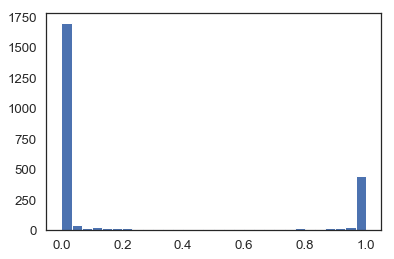

In [397]:
plt.hist(cdf_array, bins=30)

In [398]:
binom.cdf(20, 40, 0.88)

4.701387986481546e-09

In [399]:
sum(1 - cdf_array > 0.985)

1645

In [400]:
sum(cdf_array > 0.926)

476

In [401]:
high_prob_df = df[(cdf_array < (1 - 0.985)) | (cdf_array > 0.926)]

In [402]:
len(high_prob_df)

2121

In [403]:
if QUESTION == 'smooth':
    spiral_pc_to_keep = 516 / 6677
    n_spirals = int(len(df) * spiral_pc_to_keep)
    elliptical_pc_to_keep = 550 / 5904
    n_ellipticals = int(len(df) * elliptical_pc_to_keep)
    print(spiral_pc_to_keep, n_spirals, elliptical_pc_to_keep, n_ellipticals)
    high_prob_df = pd.concat([
        df.sort_values('rho_prediction')[:n_spirals],
        df.sort_values('rho_prediction', ascending=False)[:n_ellipticals]
    ])
if QUESTION == 'bars':
    n_to_keep = int(len(df) * 0.08)
    high_prob_df = pd.concat([
        df.sort_values('rho_prediction')[:int(n_to_keep/2)],
        df.sort_values('rho_prediction', ascending=False)[:int(n_to_keep/2)]
    ])



0.07728021566571813 193 0.09315718157181571 232


In [404]:
high_prob_df.sample(20)

,total_votes,k,vote_fraction,rho_prediction,png_loc,smooth,confidence_proxy
1605,47,42,0.893617,0.882290,/Volumes/alpha/gz2/png/587736/5877368093736960...,True,0.382290
291,39,5,0.128205,0.108450,/Volumes/alpha/gz2/png/587725/5877255506640241...,False,0.391550
1880,44,38,0.863636,0.881379,/Volumes/alpha/gz2/png/587742/5877420127557387...,True,0.381379
510,42,7,0.166667,0.111901,/Volumes/alpha/gz2/png/587736/5877365420168972...,False,0.388099
1134,44,39,0.886364,0.886102,/Volumes/alpha/gz2/png/587738/5877389520283896...,True,0.386102
1422,56,50,0.892857,0.880524,/Volumes/alpha/gz2/png/587739/5877391571107842...,True,0.380524
794,39,0,0.000000,0.035228,/Volumes/alpha/gz2/png/587739/5877397208325161...,False,0.464772
2384,44,40,0.909091,0.884824,/Volumes/alpha/gz2/png/587742/5877426108100775...,True,0.384824
1967,51,44,0.862745,0.883541,/Volumes/alpha/gz2/png/588848/5888488998945425...,True,0.383541
1169,44,40,0.909091,0.887785,/Volumes/alpha/gz2/png/587726/5877260156284439...,True,0.387785


In [405]:
confusion_matrix(high_prob_df['vote_fraction'] >= 0.5, high_prob_df['rho_prediction'] >= 0.5)

array([[191,   0],
       [  2, 232]])

In [406]:
error = high_prob_df[~(high_prob_df['vote_fraction'] > 0.5) & (high_prob_df['rho_prediction'] > 0.5)]

In [407]:
error

,total_votes,k,vote_fraction,rho_prediction,png_loc,smooth,confidence_proxy


In [408]:
error['vote_fraction'] > 0.5, error['rho_prediction'] > 0.5

(Series([], Name: vote_fraction, dtype: bool),
 Series([], Name: rho_prediction, dtype: bool))

In [409]:
img = Image.open(error.iloc[0]['png_loc'])
plt.imshow(img)
fontdict = {'size': 16, 'color': 'white'}
plt.text(30, 360, r'Expected vote frac $\hat{\rho}$: 0.80', fontdict=fontdict)
plt.text(30, 400, r'Observed vote frac $\frac{k}{N}$: 0.50', fontdict=fontdict)
plt.axis('off')
plt.savefig(os.path.join(save_dir, 'high_prob_error_0.png'))
plt.savefig(os.path.join(save_dir, 'high_prob_error_0.eps'))

IndexError: single positional indexer is out-of-bounds

In [410]:
img = Image.open(error.iloc[1]['png_loc'])
plt.imshow(img)
fontdict = {'size': 16, 'color': 'white'}
plt.text(30, 360, r'Expected vote frac $\hat{\rho}$: 0.13', fontdict=fontdict)
plt.text(30, 400, r'Observed vote frac $\frac{k}{N}$: 0.54', fontdict=fontdict)
plt.axis('off')
plt.savefig(os.path.join(save_dir, 'high_prob_error_1.png'))
plt.savefig(os.path.join(save_dir, 'high_prob_error_1.eps'))

IndexError: single positional indexer is out-of-bounds

In [411]:
confusion_matrix(df['vote_fraction'][:int(len(df) / 2)] > 0.5, df['rho_prediction'][:int(len(df) / 2)] > 0.5)

array([[ 239,    0],
       [   3, 1008]])

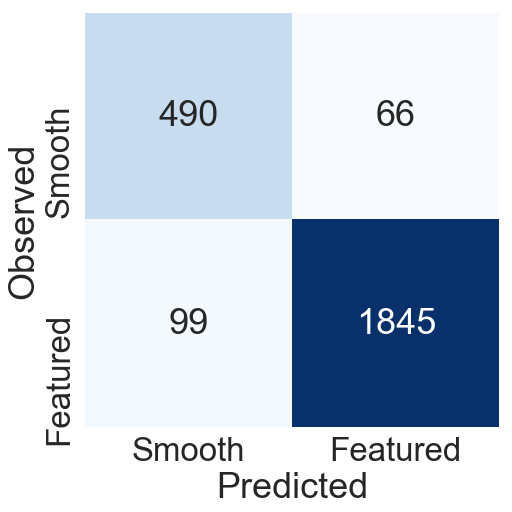

In [413]:
if QUESTION == 'smooth':
    labels = ['Smooth', 'Featured']
    
#     cm = np.array([[ 232,    2], [   0, 191]])
#     name = 'confusion_matrix_high_confidence'
    
    cm = np.array([[ 490,   66],
       [  99, 1845]])
    name = 'confusion_matrix'
    
if QUESTION == 'bars':
    labels = ['No Bar', 'Bar']
    cm = np.array([[100,    0], [   0,   100]])
    name = 'confusion_matrix_high_confidence'
    
#     cm = np.array([[1858,    81], [   189,   372]])
#     name = 'confusion_matrix'

sns.set(font_scale=3.)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False, square=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Observed')
fig.tight_layout()
fig.savefig(os.path.join(save_dir, '{}.png'.format(name)))
fig.savefig(os.path.join(save_dir, '{}.pdf'.format(name)))

In [ ]:
1 - (8 / (1159 + 83 + 8))

In [320]:
sim_model.export_performance_metrics(save_dir)

AttributeError: 'SimulatedModel' object has no attribute 'mean_square_error'

In [321]:
# Draw a galaxy, infer a range of p, redraw, and measure accuracy

In [322]:
from scipy.stats import binom

In [218]:
prange = np.linspace(0, 1., num=200)
num_galaxies = 25000
errors = 0
for n in range(num_galaxies):
    gal_n = np.random.choice(range(len(sim_model.labels)))
    rho_obs = sim_model.labels[gal_n] # same distribution as rho that we see, unbiased
    k_obs = int(rho_obs * 40)
    k_plausible = binom.rvs(n=sim_model.total_votes[gal_n], p=rho_obs)
    if (k_obs > 20 and k_plausible < 20) or (k_obs < 20 and k_plausible > 20):
        errors += 1
print(errors / num_galaxies)

0.02032


### Plot other standard acquisition visualisations

In [358]:
image_locs = sim_model.catalog['png_loc']
images = np.stack([np.array(Image.open(loc)) for loc in image_locs])

In [359]:
images.shape

(2500, 424, 424, 3)

In [360]:
acquisition_utils.save_acquisition_examples(images, sim_model.mutual_info, 'mutual_info', save_dir)

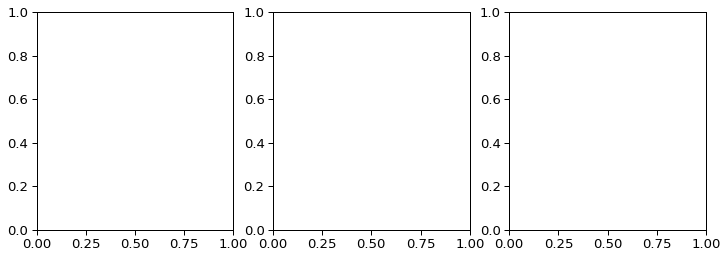

In [137]:
fig, row = plt.subplots(ncols=3, figsize=(12, 4))

In [138]:
row = sim_model.acquisition_vs_volunteer_votes(row)

### Visualise Selection of Catalog Features w.r.t. Acquisition Function

In [139]:
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20, 12))
gs = gridspec.GridSpec(6, 5, figure=fig)

<Figure size 1440x864 with 0 Axes>

#### Smooth Votes

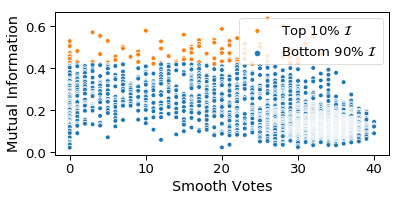

In [143]:
ax0 = plt.subplot(gs[:4, :])
sns.scatterplot(
    np.array(sim_model.catalog['smooth-or-featured_smooth_fraction'] * 40).astype(int),
    sim_model.model.mutual_info, hue=sim_model.model.mutual_info > sim_model.model.mutual_info[103],
    ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel('Smooth Votes')
ax0.legend([r'Top 10% $\mathcal{I}$', r'Bottom 90% $\mathcal{I}$'])

Text(0.5,0,'Smooth Votes')

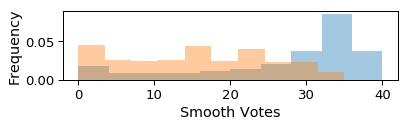

In [144]:
ax1 = plt.subplot(gs[4:, :])
ax1.hist(np.array(sim_model.labels * 40).astype(int), density=True, alpha=0.4)
ax1.hist(np.array(sim_model.labels * 40).astype(int)[:200], density=True, alpha=0.4)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Smooth Votes')

In [146]:
plt.savefig(os.path.join(save_dir, 'temp.png'))

<Figure size 432x288 with 0 Axes>

#### Redshift

Text(0.5,0,'Volunteer Votes')

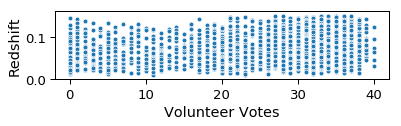

In [147]:
ax0 = plt.subplot(gs[:2, :])
sns.scatterplot(np.array(sim_model.labels * 40).astype(int), sim_model.catalog['redshift'], ax=ax0)
ax0.set_ylabel('Redshift')
ax0.set_xlabel('Volunteer Votes')

Text(0.5,0,'Volunteer Votes')

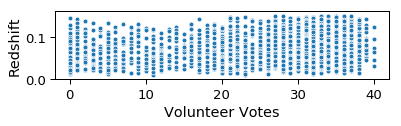

In [148]:
ax0 = plt.subplot(gs[:2, :])
sns.scatterplot(np.array(sim_model.labels * 40).astype(int), sim_model.catalog['redshift'], ax=ax0)
ax0.set_ylabel('Redshift')
ax0.set_xlabel('Volunteer Votes')

Text(0.5,0,'Redshift')

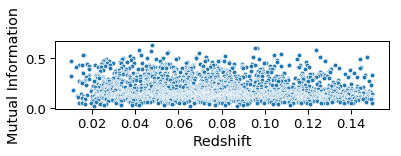

In [149]:
ax0 = plt.subplot(gs[:2, :])
sns.scatterplot(sim_model.catalog['redshift'], sim_model.model.mutual_info, ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel('Redshift')

Text(0.5,0,'Smooth Votes')

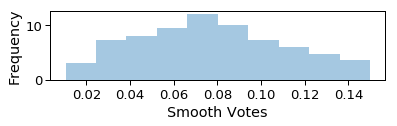

In [153]:
ax1 = plt.subplot(gs[4:, :])

ax1.hist(sim_model.catalog['redshift'], density=True, alpha=0.4)
# ax1.hist(sim_model.catalog['redshift'], density=True, alpha=0.4)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Smooth Votes')
# TODO sort by mutual information

### Below here is only relevant for DECALS, with extra questions. TODO update with GZ2 merger options?

In [299]:
merger_strs

['merging_merger',
 'merging_tidal-debris-v1',
 'merging_both-v1',
 'merging_neither-v1',
 'merging_major-disturbance',
 'merging_minor-disturbance',
 'merging_none']

In [388]:
merger_label = 'merging_major-disturbance'

Text(0.5,0,'merging_major-disturbance')

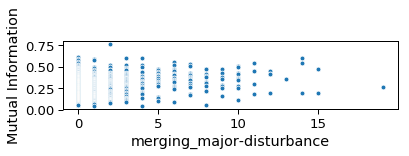

In [389]:
ax0 = plt.subplot(gs[:2, :])
sns.scatterplot(sim_model.catalog[merger_label], sim_model.model.mutual_info, ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel(merger_label)

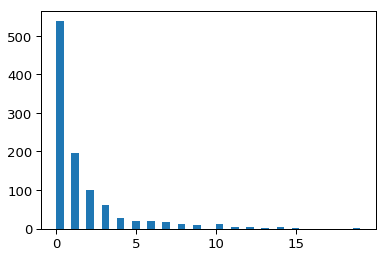

In [390]:
_ = plt.hist(sim_model.catalog[merger_label], bins=40)

In [303]:
featured_no_merger = sim_model.model.mutual_info[(sim_model.catalog[merger_label] == 0) & (sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.4)]
featured_merger = sim_model.model.mutual_info[(sim_model.catalog[merger_label] > 0) & (sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.4)]

In [391]:
featured_no_merger.mean()

0.35118675761359064

In [393]:
featured_merger.mean()

0.3618340880786661

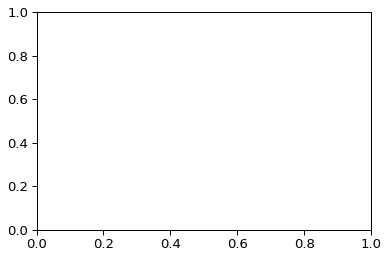

In [304]:
fig, ax = plt.subplots()

In [305]:
ax.hist(featured_no_merger, alpha=0.3, density=True)

(array([0.45991148, 0.30660766, 2.45286124, 3.98589952, 5.05902631,
        3.21938038, 2.45286124, 1.6863421 , 0.30660766, 0.30660766]),
 array([0.1173528 , 0.16676942, 0.21618604, 0.26560267, 0.31501929,
        0.36443592, 0.41385254, 0.46326916, 0.51268579, 0.56210241,
        0.61151903]),
 <a list of 10 Patch objects>)

In [306]:
ax.hist(featured_merger, alpha=0.3, density=True)

(array([0.24229288, 0.88840723, 2.90751457, 4.84585761, 3.63439321,
        1.85757875, 0.80764294, 0.16152859, 0.        , 0.08076429]),
 array([0.11109103, 0.17591673, 0.24074243, 0.30556813, 0.37039384,
        0.43521954, 0.50004524, 0.56487095, 0.62969665, 0.69452235,
        0.75934805]),
 <a list of 10 Patch objects>)

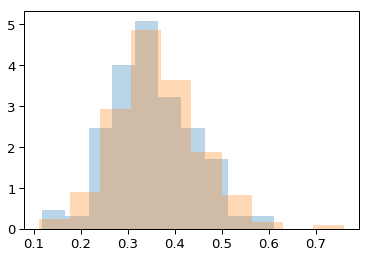

In [307]:
fig

(0, 14.5)

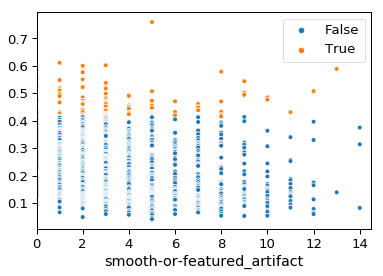

In [385]:
ax = sns.scatterplot(
    sim_model.catalog['smooth-or-featured_artifact'], 
    sim_model.model.mutual_info, 
    hue=sim_model.model.mutual_info > sim_model.model.mutual_info[103])
ax.set_xlim([0, 14.5])

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


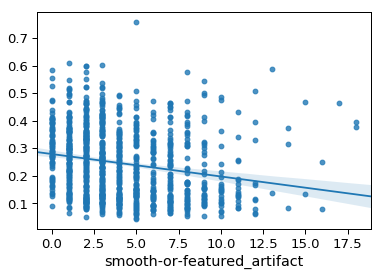

In [309]:
sns.regplot(
    sim_model.catalog['smooth-or-featured_artifact'], 
    sim_model.model.mutual_info)

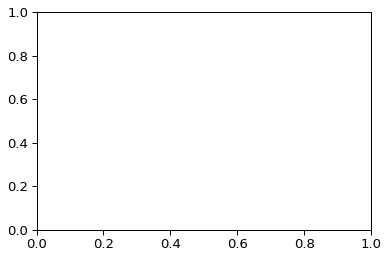

In [310]:
fig, ax = plt.subplots()

In [311]:
ax.hist(
    sim_model.catalog['smooth-or-featured_artifact'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['smooth-or-featured_artifact'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

(array([0.11014807, 0.17515349, 0.11616709, 0.07162634, 0.0288913 ,
        0.03310461, 0.01504755, 0.00240761, 0.00180571, 0.0012038 ]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <a list of 10 Patch objects>)

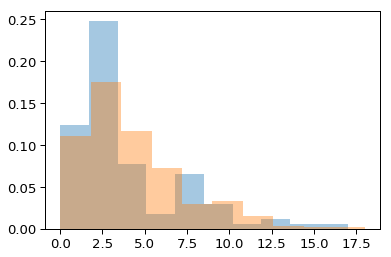

In [312]:
fig

In [313]:
has-spiral-arms_yes
spiral-winding_prediction-encoded

NameError: name 'has' is not defined

In [318]:
sns.scatterplot(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.5], 
    sim_model.model.mutual_info[sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.5], 
    hue=sim_model.model.mutual_info > sim_model.model.mutual_info[100])

ValueError: arrays must all be same length

(array([0.16495125, 0.02004334, 0.00893824, 0.01110509, 0.00731311,
        0.00270856, 0.0067714 , 0.01110509, 0.00839653, 0.00866739]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <a list of 10 Patch objects>)

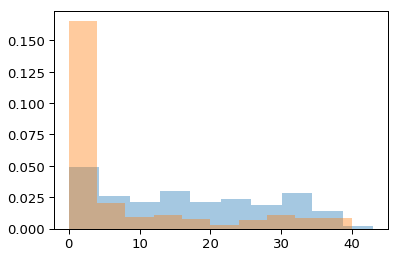

In [316]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

(array([ 0.94125923,  4.05465512,  5.5751508 ,  7.24045558,  9.41259225,
        12.01915626,  7.45766925,  8.32652391,  5.71995991,  6.08198269]),
 array([9.04981134e-05, 1.50539712e-02, 3.00174442e-02, 4.49809172e-02,
        5.99443903e-02, 7.49078633e-02, 8.98713364e-02, 1.04834809e-01,
        1.19798282e-01, 1.34761756e-01, 1.49725229e-01]),
 <a list of 10 Patch objects>)

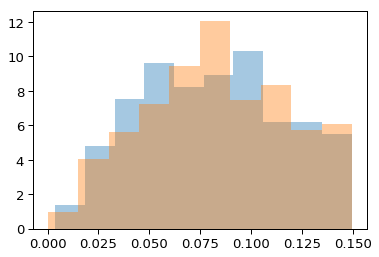

In [386]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['redshift'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['redshift'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

(array([0.38889206, 0.08211211, 0.0222387 , 0.01539602, 0.00798312,
        0.00570223, 0.00228089, 0.00114045, 0.        , 0.00057022]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

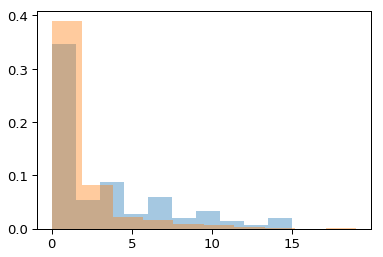

In [387]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['merging_major-disturbance'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['merging_major-disturbance'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [455]:
for merger_label in merger_strs:
    print('\n' + merger_label)
    print(sim_model.model.mutual_info[sim_model.catalog[merger_label] > 1].mean())
    print(sim_model.model.mutual_info[sim_model.catalog[merger_label] == 1].mean())


merging_merger
0.2511509739575972
0.25096607272032195

merging_tidal-debris-v1
0.3034175803458046
0.23293615612694835

merging_both-v1
0.3219326360535824
0.26581695784524834

merging_neither-v1
0.24475130393558714
0.3423252674734375

merging_major-disturbance
0.2972217606913461
0.23137436019256713

merging_minor-disturbance
0.260792108234764
0.20166867936737748

merging_none
0.24643256291318852
0.24930844070251124


In [478]:
data = [
    {'Volunteer Response': 'Merging', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_both-v1'] > 1].mean()},
    {'Volunteer Response': 'Major Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_major-disturbance'] > 1].mean()},
    {'Volunteer Response': 'Minor Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_minor-disturbance'] > 1].mean()},
    {'Volunteer Response': 'No Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_none'] > 20].mean()}
    ]

In [479]:
df = pd.DataFrame(data)

In [480]:
df.head()

,Mean Mutual Information,Volunteer Response
0,0.321933,Merging
1,0.297222,Major Disturbance
2,0.260792,Minor Disturbance
3,0.219533,No Disturbance


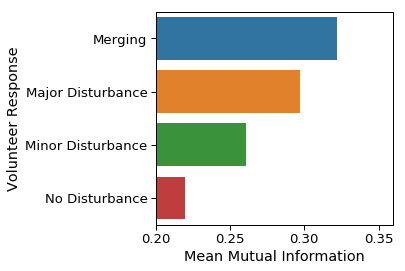

In [481]:
fig, ax = plt.subplots()
ax = sns.barplot(data=df, y='Volunteer Response', x='Mean Mutual Information', ax=ax)
ax.set_xlim([0.2, 0.36])
fig.tight_layout()

In [406]:
print(sim_model.model.mutual_info[(sim_model.catalog['merging_minor-disturbance'] + sim_model.catalog['merging_major-disturbance']) > 0].mean())
print(sim_model.model.mutual_info[(sim_model.catalog['merging_minor-disturbance'] + sim_model.catalog['merging_major-disturbance']) == 0].mean())

0.25065622588200587
0.2357066434226222


(array([602., 155.,   0.,  94.,   0.,  57.,   0.,  33.,   0.,  19.,   0.,
         13.,   0.,  16.,   0.,   9.,   0.,   6.,   0.,   4.,   5.,   0.,
          2.,   0.,   2.,   0.,   2.,   0.,   3.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([ 0.   ,  0.525,  1.05 ,  1.575,  2.1  ,  2.625,  3.15 ,  3.675,
         4.2  ,  4.725,  5.25 ,  5.775,  6.3  ,  6.825,  7.35 ,  7.875,
         8.4  ,  8.925,  9.45 ,  9.975, 10.5  , 11.025, 11.55 , 12.075,
        12.6  , 13.125, 13.65 , 14.175, 14.7  , 15.225, 15.75 , 16.275,
        16.8  , 17.325, 17.85 , 18.375, 18.9  , 19.425, 19.95 , 20.475,
        21.   ]),
 <a list of 40 Patch objects>)

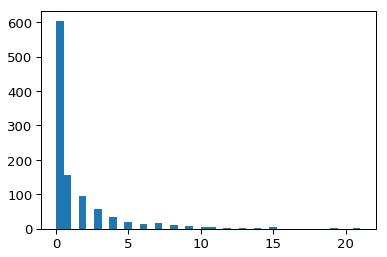

In [407]:
plt.hist(sim_model.catalog['merging_tidal-debris-v1'], bins=40)

0.2705853379023123

0.22372988551706502